## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

# """
# 建立神經網路，並加入 BN layer
# """
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation Accuracy
"""
from keras.callbacks import EarlyStopping

earlystops = [

    EarlyStopping(monitor="val_accuracy", 
                              patience=5, 
                              verbose=1
                              ),
    EarlyStopping(monitor="val_accuracy", 
                              patience=10, 
                              verbose=1
                              ),
    EarlyStopping(monitor="val_accuracy", 
                              patience=25, 
                              verbose=1
                              )
]

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for early_stop in earlystops:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with early_stop = %.6f" % (early_stop.patience))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[early_stop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    tag = f'early_stop: {early_stop.patience}'
    results[tag] = {'train-loss': train_loss,
                 'valid-loss': valid_loss,
                 'train-acc': train_acc,
                 'valid-acc': valid_acc}

Experiment with early_stop = 5.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3

50000/50000 [==============================] - 11s 224us/step - loss: 2.2048 - accuracy: 0.2729 - val_loss: 2.1387 - val_accuracy: 0.1896
Epoch 2/50
50000/50000 [==============================] - 11s 230us/step - loss: 1.7343 - accuracy: 0.3964 - val_loss: 1.9444 - val_accuracy: 0.3288
Epoch 3/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.6115 - accuracy: 0.4362 - val_loss: 1.8034 - val_accuracy: 0.3855
Epoch 4/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.5367 - accuracy: 0.4632 - val_loss: 1.6985 - val_accuracy: 0.4188
Epoch 5/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.4821 - accuracy: 0.4804 - val_loss: 1.6230 - val_accuracy: 0.4409
Epoch 6/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.4375 - accuracy: 0.4976 - val_loss: 1.5770 - val_accuracy: 0.4483
Epoch 7/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.3992 - accuracy: 0.5102 - val_loss

50000/50000 [==============================] - 12s 235us/step - loss: 1.3115 - accuracy: 0.5433 - val_loss: 1.5104 - val_accuracy: 0.4669
Epoch 11/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.2817 - accuracy: 0.5588 - val_loss: 1.4906 - val_accuracy: 0.4730
Epoch 12/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.2558 - accuracy: 0.5640 - val_loss: 1.4962 - val_accuracy: 0.4719
Epoch 13/50
50000/50000 [==============================] - 12s 230us/step - loss: 1.2277 - accuracy: 0.5760 - val_loss: 1.4824 - val_accuracy: 0.4746
Epoch 14/50
50000/50000 [==============================] - 12s 230us/step - loss: 1.2035 - accuracy: 0.5842 - val_loss: 1.4755 - val_accuracy: 0.4790
Epoch 15/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.1785 - accuracy: 0.5935 - val_loss: 1.4693 - val_accuracy: 0.4800
Epoch 16/50
50000/50000 [==============================] - 11s 230us/step - loss: 1.1536 - accuracy: 0.6027 - va

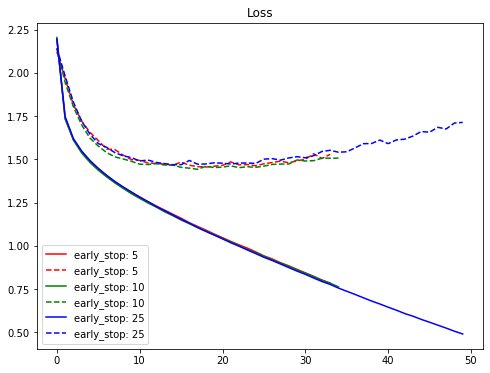

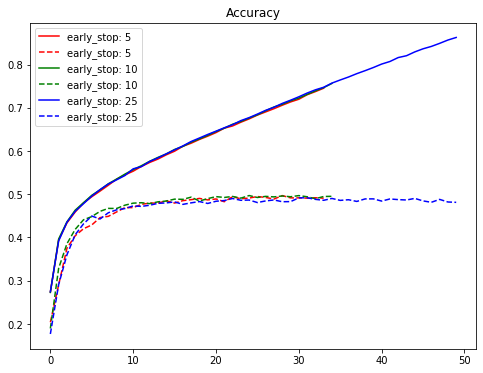

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()